<a href="https://colab.research.google.com/github/curiouser001/Installations_Mac_Ubuntu_Windows/blob/master/custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.19-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!unzip '/content/drive/My Drive/finaldataset.zip' -d 'finaldataset'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import timeit

In [0]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False,k_size=3,padding_size=1):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=k_size, padding=padding_size)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def _vgg(arch, cfg, batch_norm, pretrained, progress,k_size,padding_size, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm,k_size=k_size,padding_size=padding_size), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model



cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


In [0]:
from sklearn.metrics import roc_curve, auc




def run(data,vgg,epoch,name):
    learn = cnn_learner(data, vgg, pretrained=False, metrics=[error_rate,accuracy])
    start = timeit.default_timer()
    learn.fit_one_cycle(epoch)
    stop = timeit.default_timer()
    print(name, stop - start)
    learn.save(name)
    learn.recorder.plot_losses()
    # predict the validation set with our model
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(title='Confusion matrix')
    interp.confusion_matrix()
    preds,y, loss = learn.get_preds(with_loss=True)

    # get accuracy
    acc = accuracy(preds, y)
    print('The accuracy is {0} %.'.format(acc))
        

    preds,y, loss = learn.get_preds(with_loss=True)

    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area is {0}'.format(roc_auc))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    return learn

In [0]:
imagesize = 224
batchsize = 64
path = 'finaldataset/finaldataset/'

tfms = get_transforms(do_flip=False,
                      flip_vert=False,
                      max_rotate=15.0,
                      max_zoom=1,
                      max_lighting=None,
                      max_warp=None,
                      p_affine=0.0,
                      p_lighting=0.0)

data = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='val')
        .label_from_folder()
        .transform(tfms, size=imagesize)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.499332,4.785338,0.785498,0.214502,01:33
1,1.272205,4.162159,0.737160,0.262840,01:32
2,1.107785,0.910313,0.323263,0.676737,01:31
3,0.978432,0.904419,0.326284,0.673716,01:33
4,0.900057,0.767403,0.271903,0.728097,01:34
5,0.838655,3.228285,0.564955,0.435045,01:33
6,0.774772,0.676524,0.241692,0.758308,01:32
7,0.700221,0.734185,0.287009,0.712991,01:32
8,0.612144,0.543860,0.184290,0.815710,01:33
9,0.549363,0.603565,0.175227,0.824773,01:33


vgg19-3x3 2798.9462680439974


The accuracy is 0.8731117844581604 %.


ROC area is 0.9959324791539556


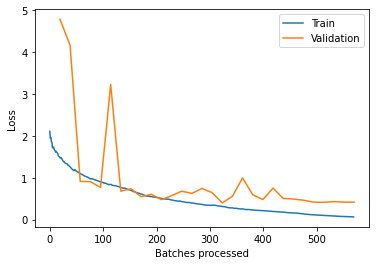

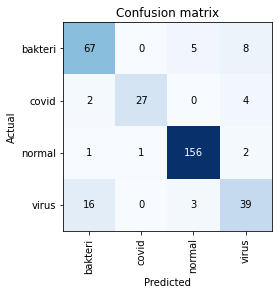

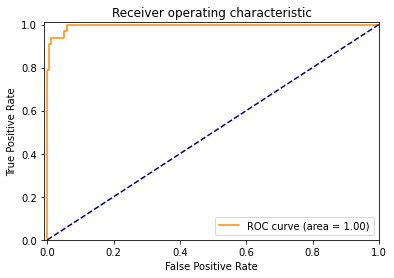

In [15]:
def vgg19_bn3x3(pretrained=False, progress=True,k_size=3,padding_size=1, **kwargs):
    return _vgg('vgg19_bn', 'E', True, pretrained, progress,k_size,padding_size, **kwargs)
learn_vgg19_3x3 = run(data, vgg19_bn3x3, 30,'vgg19-3x3')

In [0]:
def vgg16_bn5x5(pretrained=False, progress=True,k_size=5,padding_size=2, **kwargs):
    return _vgg('vgg16_bn', 'A', True, pretrained, progress,k_size,padding_size, **kwargs)
learn_vgg16_5x5 = run(data, vgg16_bn5x5, 100,'vgg16-5x5')